In [9]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/BP_data.csv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data)
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [11]:
#결측치
df['Genetic_Pedigree_Coefficient'] = df['Genetic_Pedigree_Coefficient'].fillna(df['Genetic_Pedigree_Coefficient'].mean())
df['alcohol_consumption_per_day'] = df['alcohol_consumption_per_day'].fillna(df['alcohol_consumption_per_day'].median())

df.drop(columns=['Patient_Number', 'Pregnancy'], inplace=True, errors='ignore')

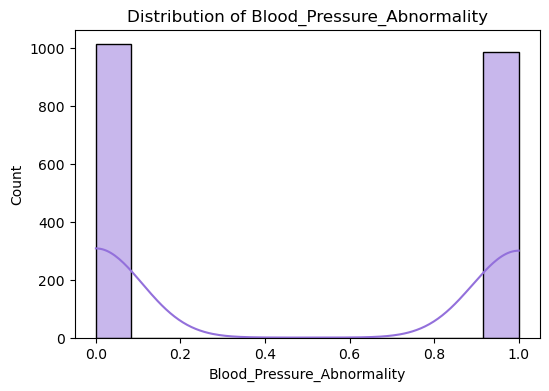

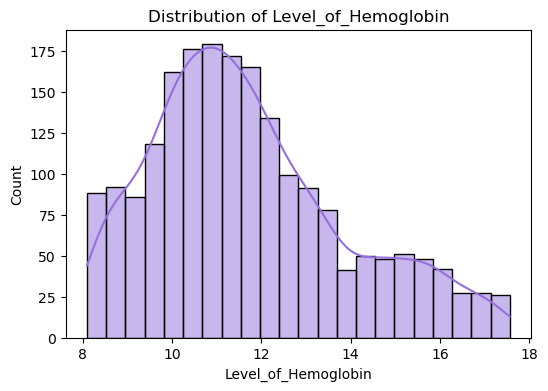

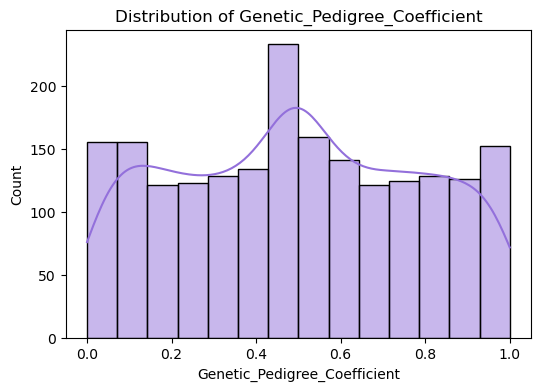

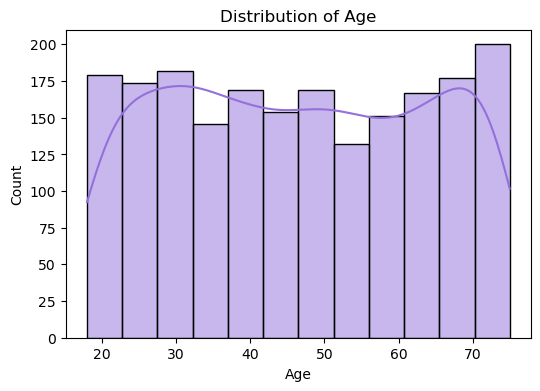

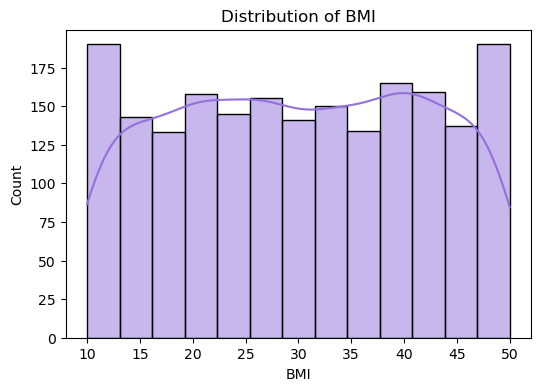

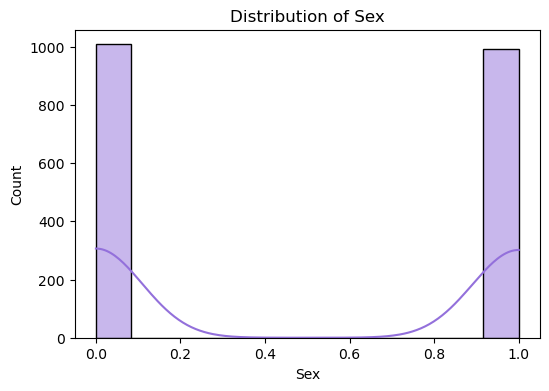

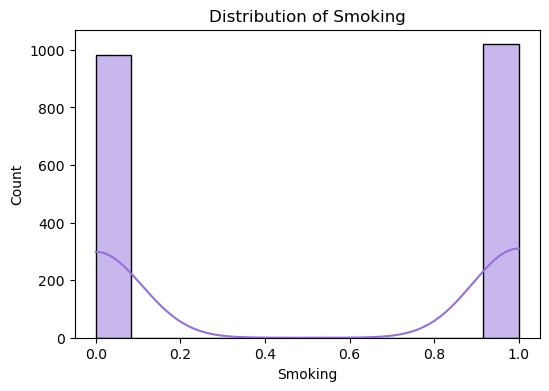

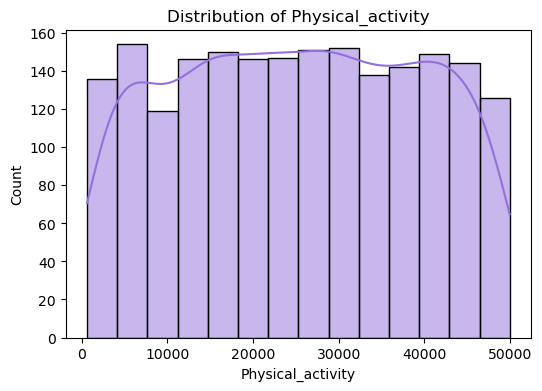

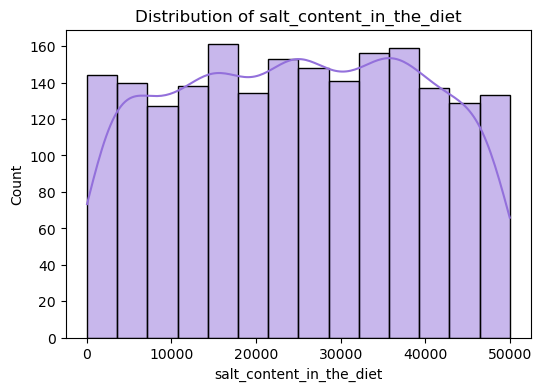

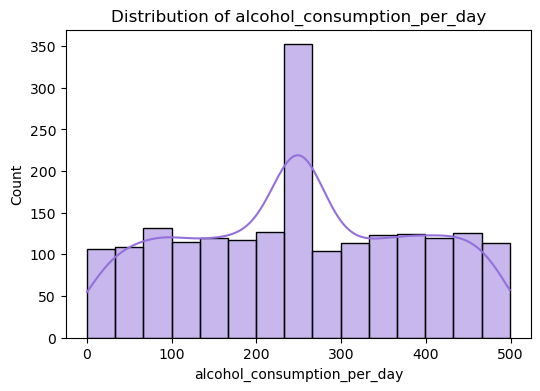

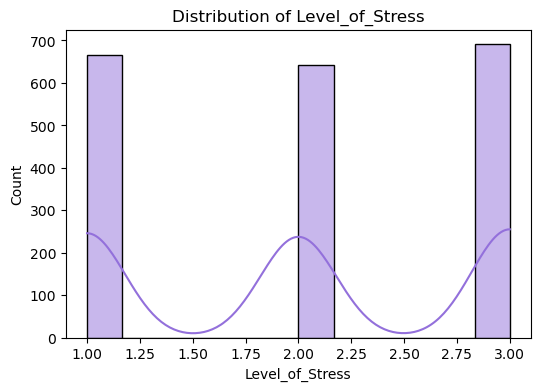

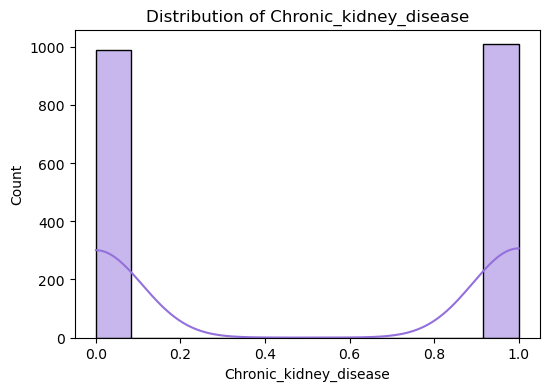

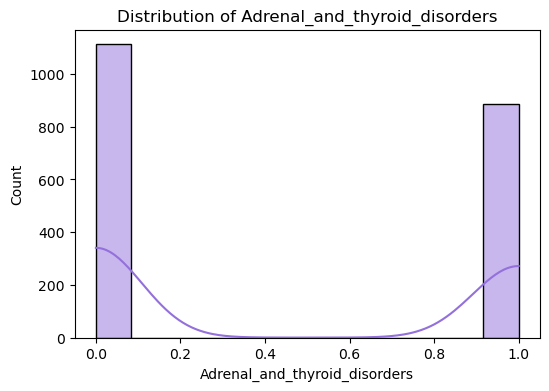

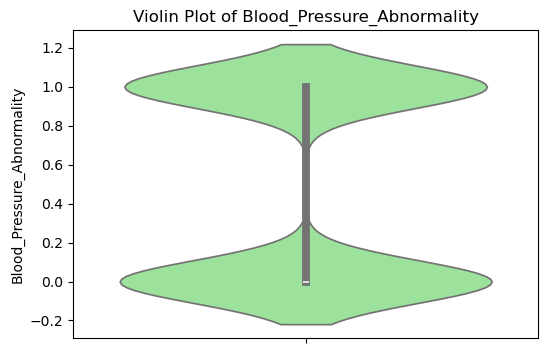

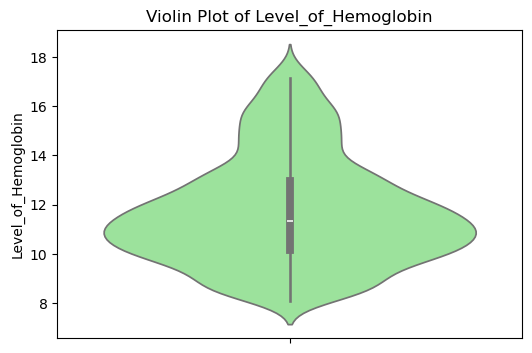

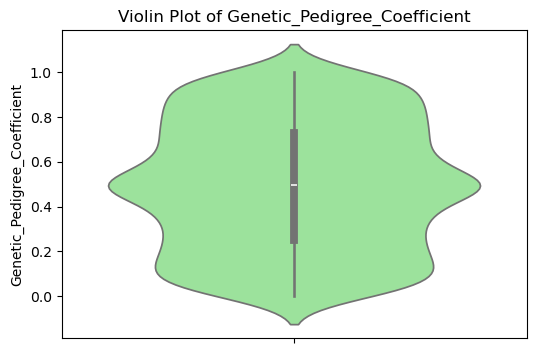

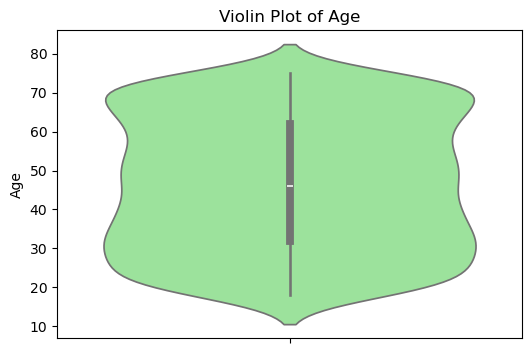

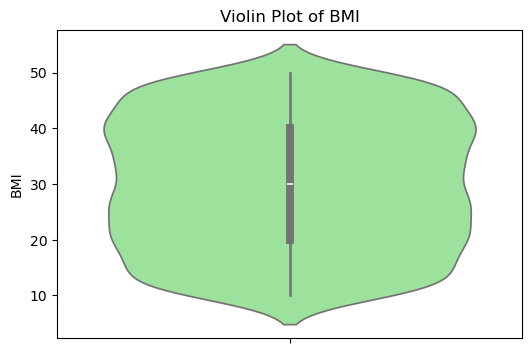

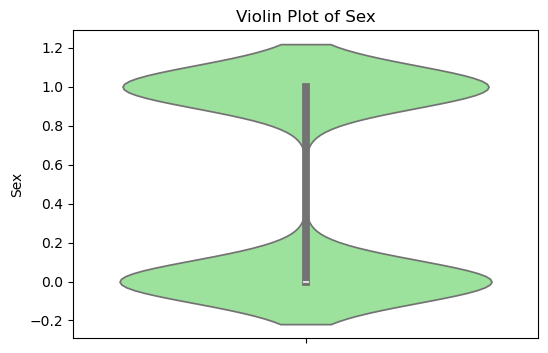

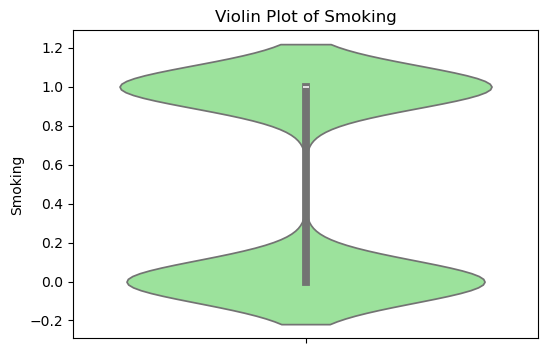

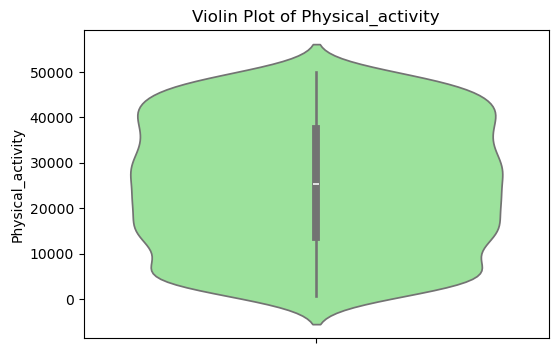

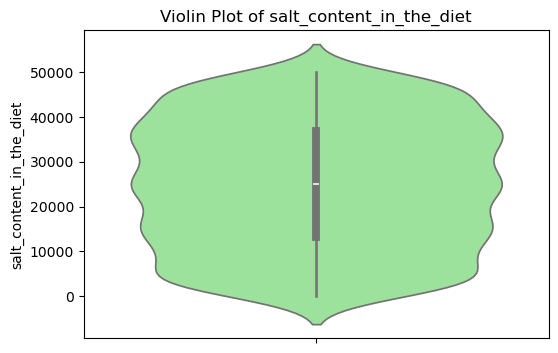

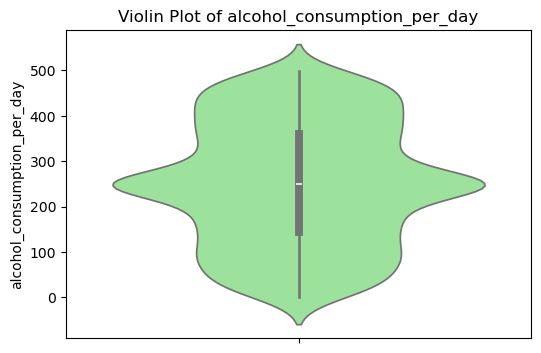

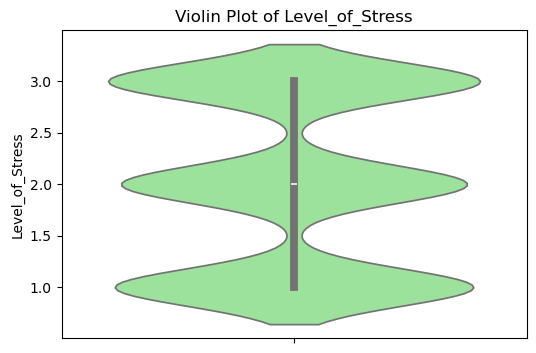

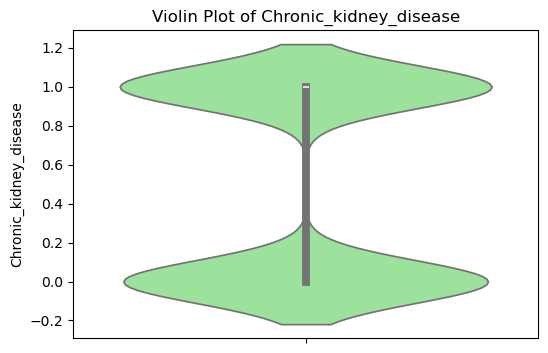

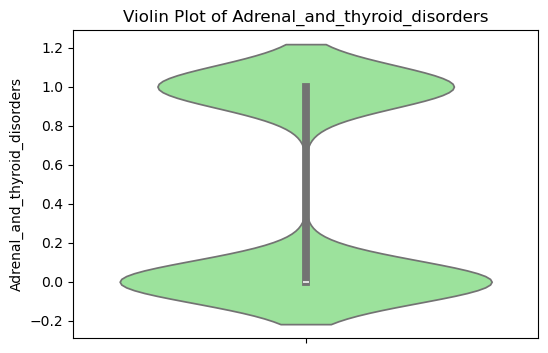

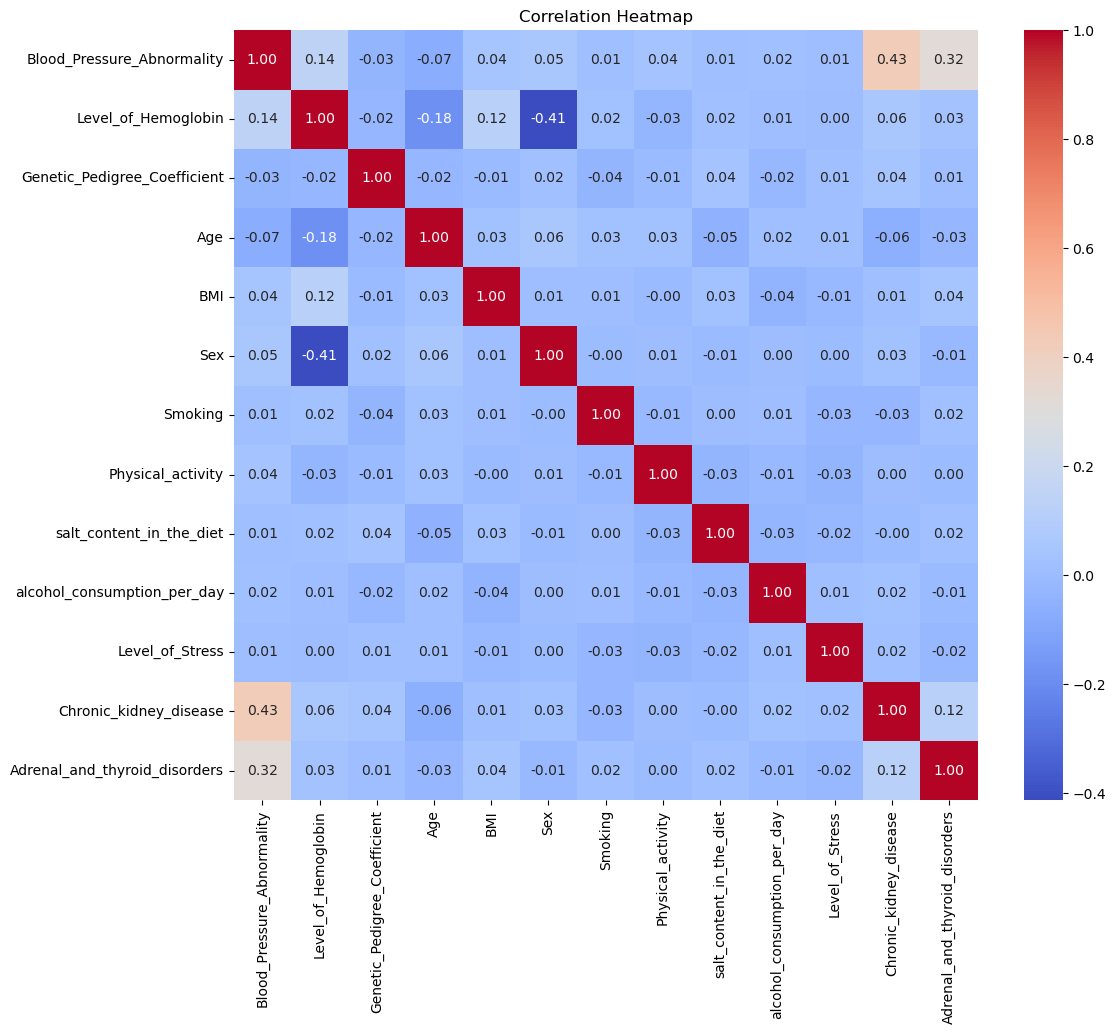

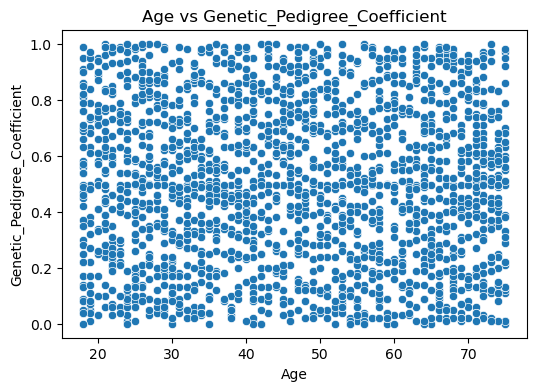

In [13]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='mediumpurple')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y=df[col], color='lightgreen')
    plt.title(f'Violin Plot of {col}')
    plt.ylabel(col)
    plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

if 'Genetic_Pedigree_Coefficient' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='Age', y='Genetic_Pedigree_Coefficient', data=df)
    plt.title('Age vs Genetic_Pedigree_Coefficient')
    plt.xlabel('Age')
    plt.ylabel('Genetic_Pedigree_Coefficient')
    plt.show()

In [92]:
#BMI 비만도 -> 연속형 목표
X = df.drop(columns=['BMI'])
y = df['BMI']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [93]:
#tensor로 변
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [94]:
#이거 안해도? 문제없음 -> 왜 하냐
#대이터로드 상태로는 배치나 shuffle 가능 즉, 속도 빠르고, 과적합 줄일수 있음 -by GPT
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [95]:
class RegNet(nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        out = self.fc4(x)
        return out

model = RegNet()

In [96]:
loss_fn = nn.MSELoss()
optm = optim.Adam(model.parameters(), lr=0.0005)

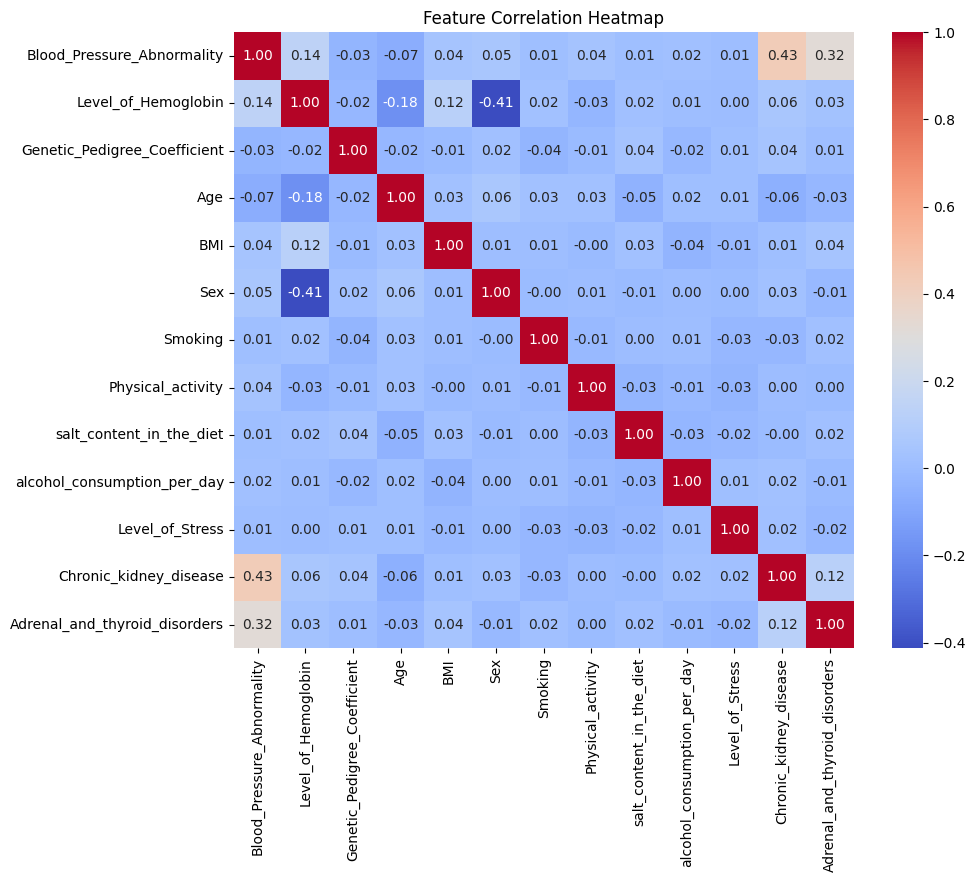

In [97]:
#heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [98]:
epochs = 100
losses = []

for ep in range(epochs):
    model.train()
    run_loss = 0.0

    for xb, yb in train_dl:
        optm.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optm.step()
        run_loss += loss.item()

    losses.append(run_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        te_pred = model(X_test)
        te_loss = loss_fn(te_pred, y_test)
        print(f"[{ep+1}/{epochs}] Train Loss: {run_loss/len(train_dl):.4f}, Test Loss: {te_loss.item():.4f}")

#로스가 안줄어... 아마 히트맵 보면 BMI랑 상관관계가 높은게 아무것도 없어서 그러는 것 같음.


[1/100] Train Loss: 1001.8647, Test Loss: 911.2191
[2/100] Train Loss: 628.5740, Test Loss: 272.5617
[3/100] Train Loss: 163.0601, Test Loss: 148.7081
[4/100] Train Loss: 143.3986, Test Loss: 145.4224
[5/100] Train Loss: 141.4651, Test Loss: 144.8049
[6/100] Train Loss: 139.9692, Test Loss: 144.5633
[7/100] Train Loss: 139.2644, Test Loss: 144.1923
[8/100] Train Loss: 138.5216, Test Loss: 144.2769
[9/100] Train Loss: 137.9253, Test Loss: 144.7200
[10/100] Train Loss: 137.2656, Test Loss: 143.8349
[11/100] Train Loss: 136.3792, Test Loss: 145.4092
[12/100] Train Loss: 136.4005, Test Loss: 143.6188
[13/100] Train Loss: 135.2950, Test Loss: 143.3983
[14/100] Train Loss: 135.0289, Test Loss: 143.3483
[15/100] Train Loss: 134.4057, Test Loss: 143.4545
[16/100] Train Loss: 134.4597, Test Loss: 143.5429
[17/100] Train Loss: 133.5121, Test Loss: 144.1399
[18/100] Train Loss: 133.3789, Test Loss: 143.4237
[19/100] Train Loss: 132.4870, Test Loss: 144.3443
[20/100] Train Loss: 132.3183, Test Los

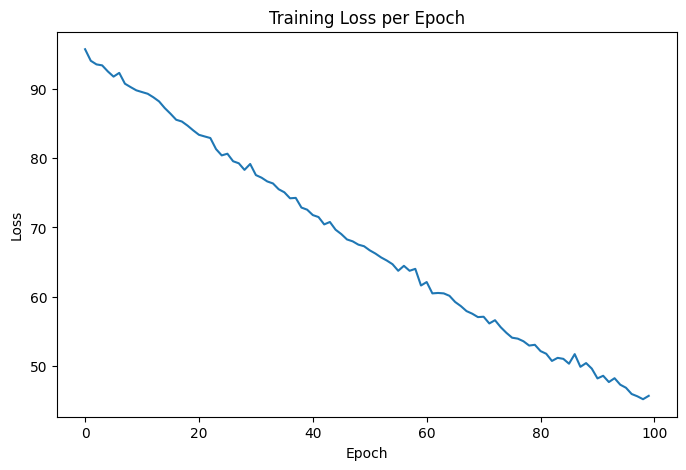

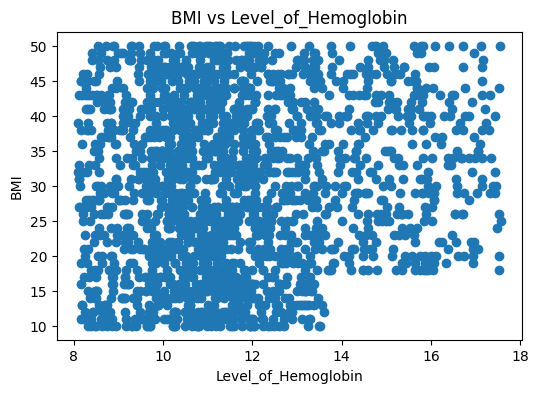

In [87]:
# Loss
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#scatter plot
plt.figure(figsize=(6,4))
plt.scatter(df['Level_of_Hemoglobin'], df['BMI'])
plt.xlabel('Level_of_Hemoglobin')
plt.ylabel('BMI')
plt.title('BMI vs Level_of_Hemoglobin')
plt.show()

In [99]:
#완전 산포형 BMI 값 예측하는데 진짜 1도 도움 안됨 -> 히트맵에 나와있는 것과 동일한 의미.

In [100]:
#그래서 타겟을 Genetic_Pedigree_Coefficient로 바꿈

In [101]:
target_column = 'Genetic_Pedigree_Coefficient'

In [102]:
X = df.drop(columns=[target_column])
y = df[target_column]

In [104]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [105]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 데이터로드 (아까랑 똑같은거)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [106]:
class RegNet(nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        out = self.fc4(x)
        return out

model = RegNet()

In [107]:
loss_fn = nn.MSELoss()
optm = optim.Adam(model.parameters(), lr=0.001)

In [109]:
epochs = 50
losses = []

for ep in range(epochs):
    model.train()
    run_loss = 0.0

    for xb, yb in train_dl:
        optm.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optm.step()
        run_loss += loss.item()

    losses.append(run_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        te_pred = model(X_test)
        te_loss = loss_fn(te_pred, y_test)
        print(f"[{ep+1}/{epochs}] Train Loss: {run_loss/len(train_dl):.6f}, Test Loss: {te_loss.item():.6f}")

[1/50] Train Loss: 0.002496, Test Loss: 0.130216
[2/50] Train Loss: 0.002190, Test Loss: 0.134280
[3/50] Train Loss: 0.002017, Test Loss: 0.130972
[4/50] Train Loss: 0.001867, Test Loss: 0.130576
[5/50] Train Loss: 0.002205, Test Loss: 0.131558
[6/50] Train Loss: 0.001999, Test Loss: 0.132978
[7/50] Train Loss: 0.002012, Test Loss: 0.132970
[8/50] Train Loss: 0.002476, Test Loss: 0.129290
[9/50] Train Loss: 0.002626, Test Loss: 0.129239
[10/50] Train Loss: 0.002772, Test Loss: 0.134273
[11/50] Train Loss: 0.002557, Test Loss: 0.130468
[12/50] Train Loss: 0.002451, Test Loss: 0.134187
[13/50] Train Loss: 0.002577, Test Loss: 0.129030
[14/50] Train Loss: 0.002811, Test Loss: 0.133163
[15/50] Train Loss: 0.002936, Test Loss: 0.132607
[16/50] Train Loss: 0.003740, Test Loss: 0.134324
[17/50] Train Loss: 0.003436, Test Loss: 0.131203
[18/50] Train Loss: 0.003006, Test Loss: 0.131347
[19/50] Train Loss: 0.002820, Test Loss: 0.133720
[20/50] Train Loss: 0.002794, Test Loss: 0.132066
[21/50] T

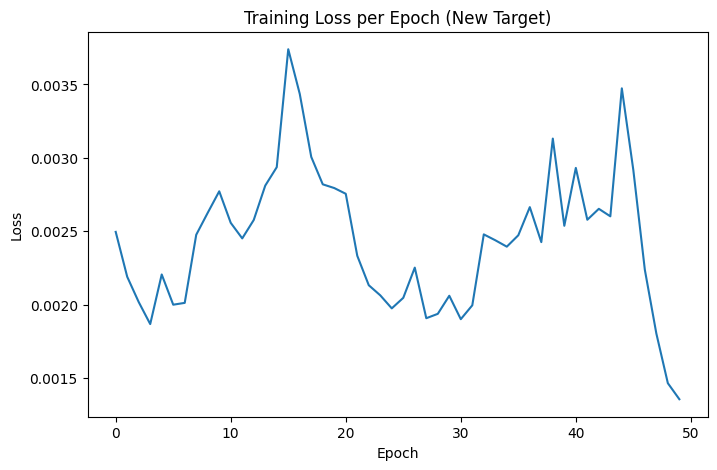

In [110]:
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.title('Training Loss per Epoch (New Target)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
#good